In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data,augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model3
import numpy.random as rnd
from cs231n.data_utils import load_CIFAR10 
from Loss_metrics import Prob_dist, YUV2rgb, assign_bin

In [2]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    plt.show()
    return

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    plt.show()
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


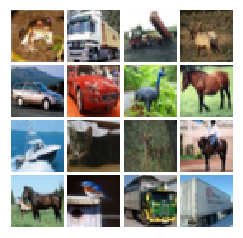

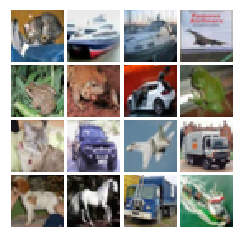

In [4]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
show_images(X_train[:16])
show_images(X_test[:16])

1.0


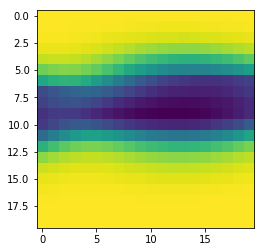

In [5]:
import scipy 
yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
dist = np.zeros([400])
X_YUV = X_train.dot(yuv_converter)
ab = assign_bin(X_YUV)
np.add.at(dist, ab, 1)
dist = dist/np.sum(dist)
normalized = scipy.ndimage.filters.gaussian_filter(dist, 5, order=0)
print(np.sum(normalized))
lamda = 0.5
inv_wgt = (1-lamda)*normalized + lamda/400
wgt = 1/inv_wgt
plt.imshow(wgt.reshape([20,20]))
plt.show()

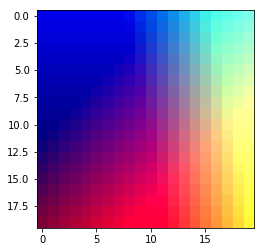

In [6]:
#Visualizing the bins
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])
y_comp = 0.5*np.ones((20, 20))
bins_a = np.zeros((20, 20))
bins_b = np.zeros((20, 20))
for i in range(20):
    for j in range(20):
        bins_a[i, j] = (i/19)*1.2 - 0.6
        bins_b[i, j] = (j/19)*1.2 - 0.6

YUV_output = np.concatenate((y_comp[...,np.newaxis],bins_a[...,np.newaxis],bins_b[...,np.newaxis]),axis = 2)
RGB_output = YUV_output.dot(inv_mat)   
RGB_output[RGB_output>1] = 1
RGB_output[RGB_output<0] = 0 
plt.imshow(RGB_output)
plt.show()

0
223.436840397


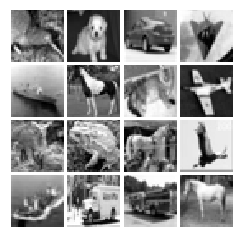

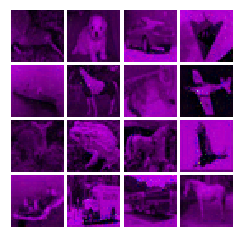

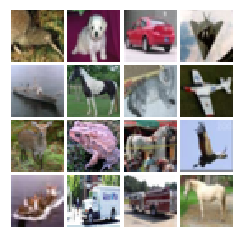

100
215.976797277


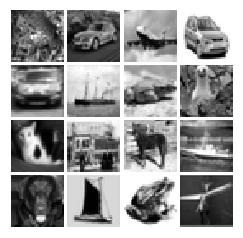

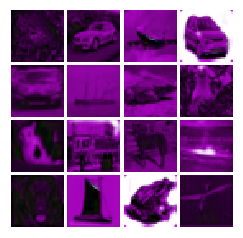

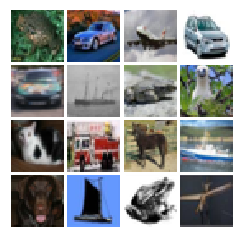

200
227.769400183


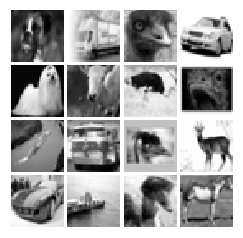

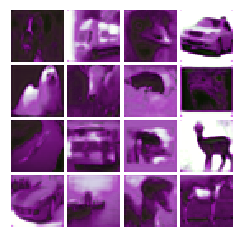

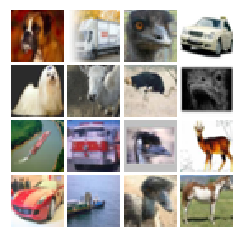

300
211.717127638


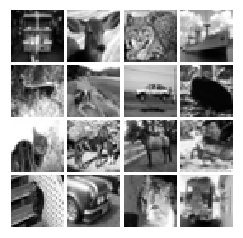

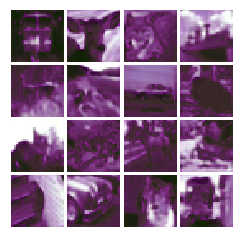

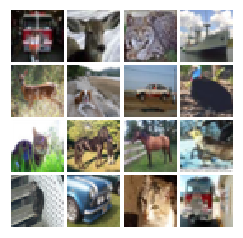

400
179.378645345


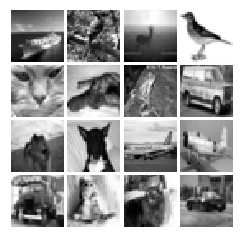

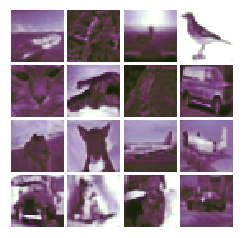

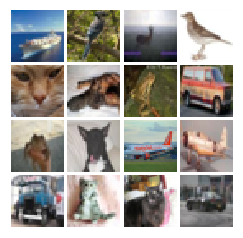

500
253.000218234


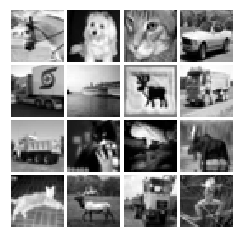

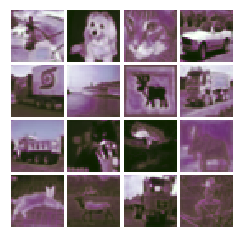

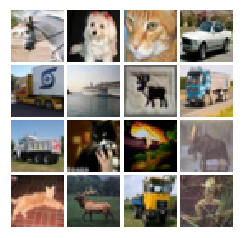

600
213.343826407


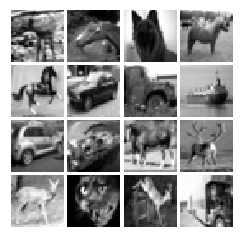

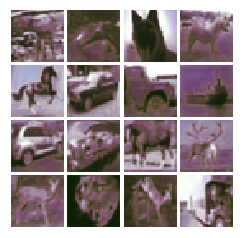

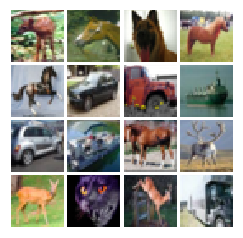

700
192.041367464


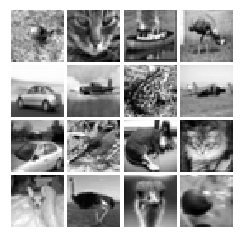

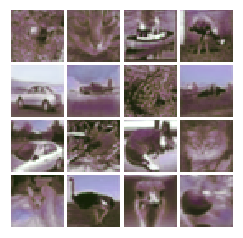

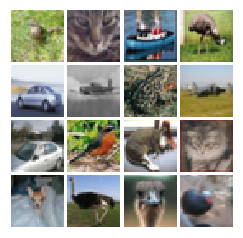

800
180.768838753


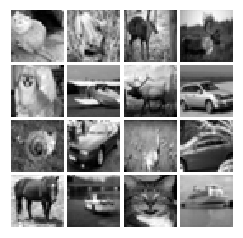

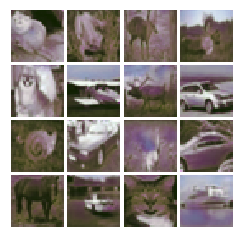

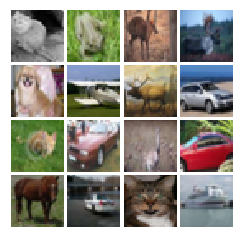

900
190.269087115


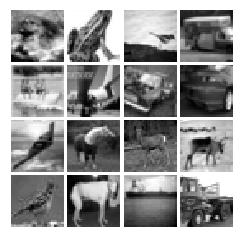

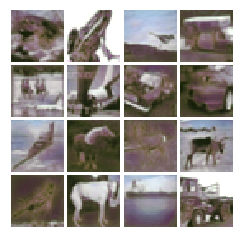

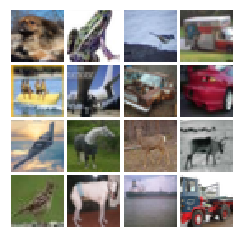

1000
305.067223495


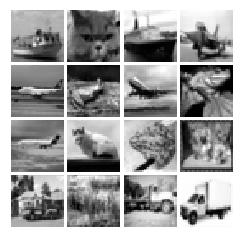

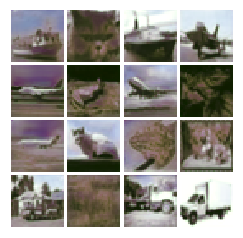

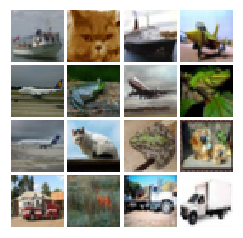

1100
200.00640772


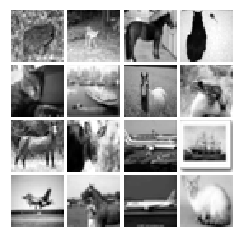

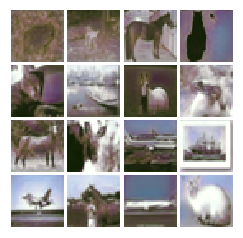

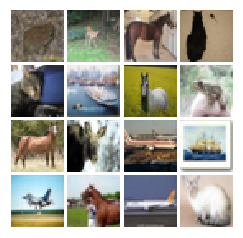

1200
180.006883459


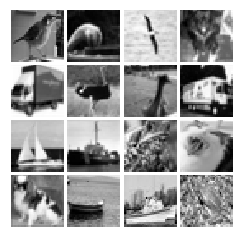

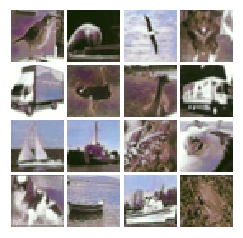

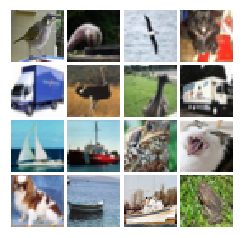

1300
173.867942194


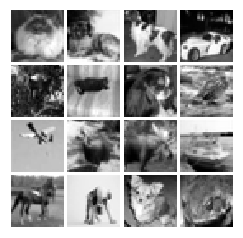

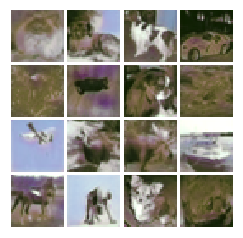

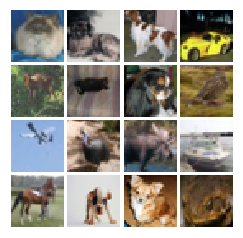

1400
188.583356319


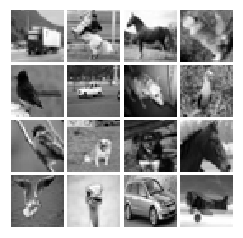

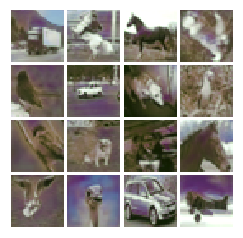

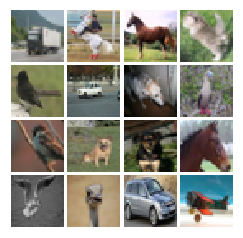

1500
331.721293585


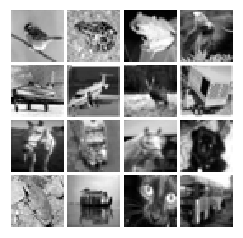

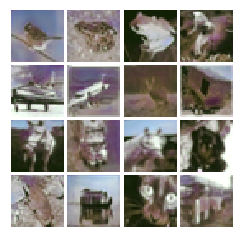

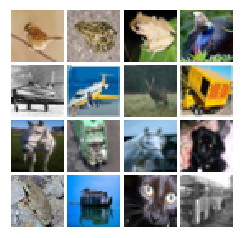

1600
159.856533597


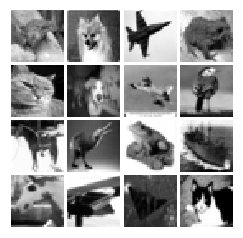

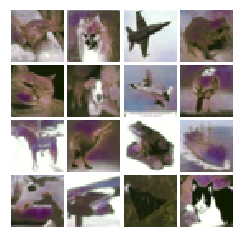

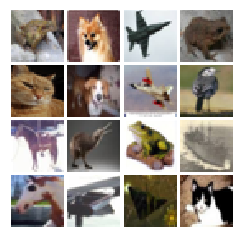

1700
174.364485299


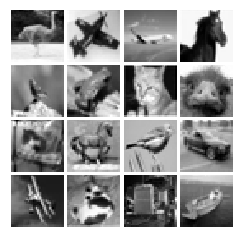

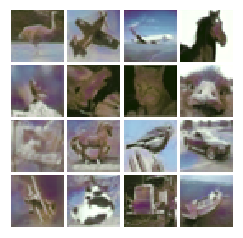

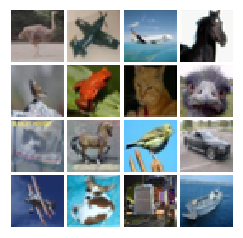

1800
166.014563358


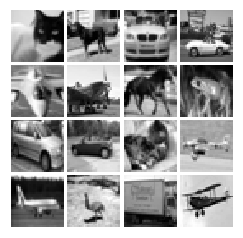

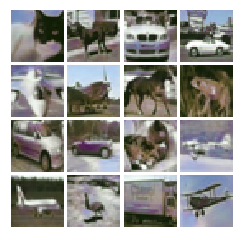

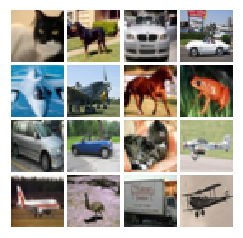

1900
208.056228786


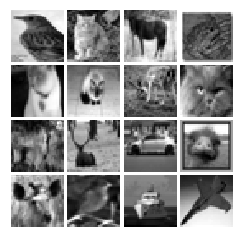

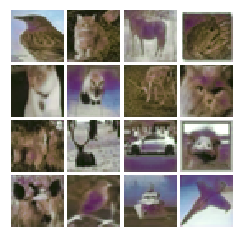

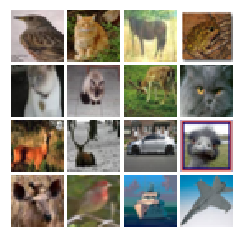

2000
217.847232212


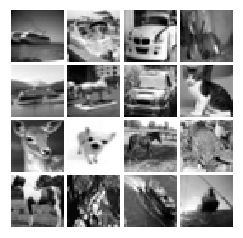

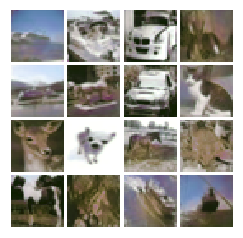

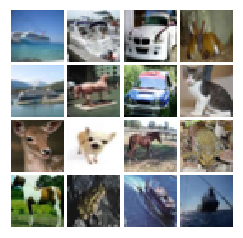

2100
177.675369828


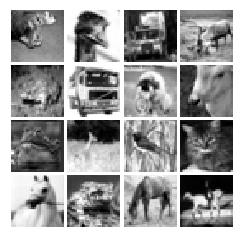

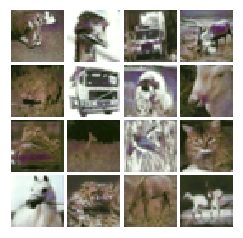

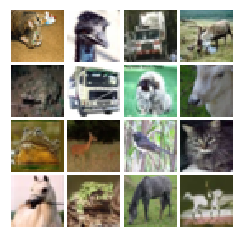

2200
248.084093603


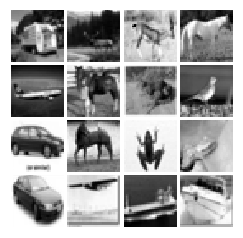

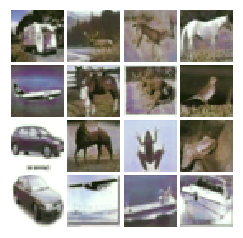

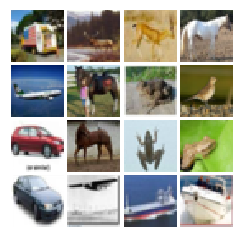

2300
165.987930884


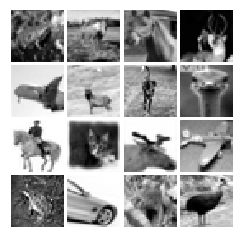

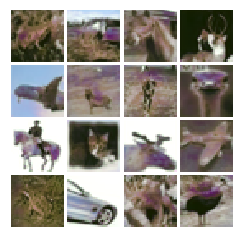

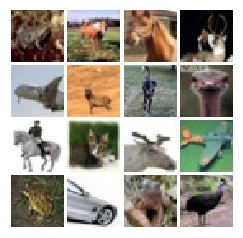

2400
161.480741976


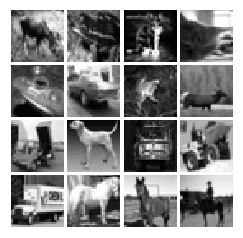

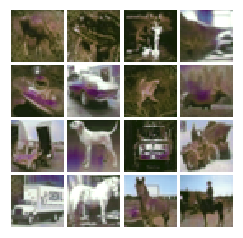

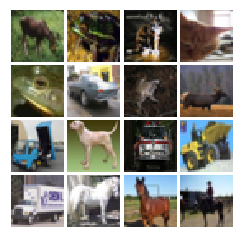

2500
251.422473287


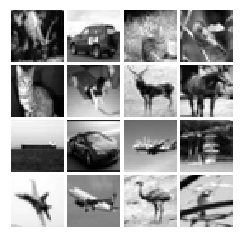

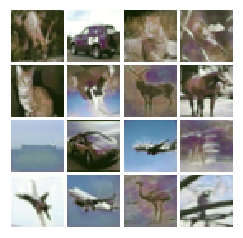

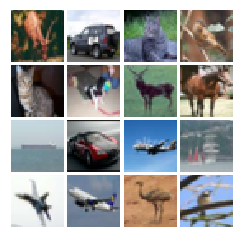

2600
172.094836732


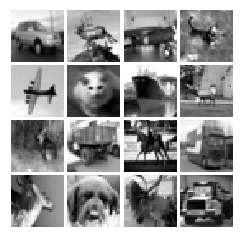

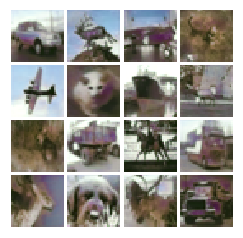

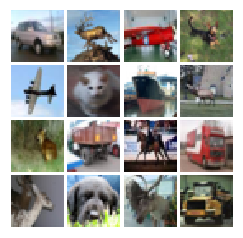

2700
168.307926179


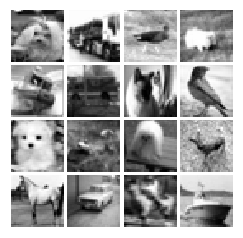

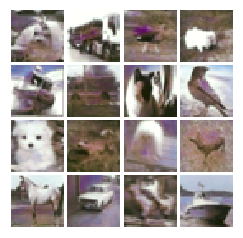

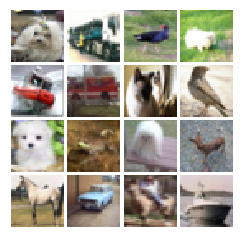

2800
189.257142066


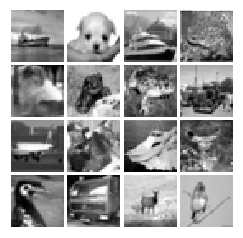

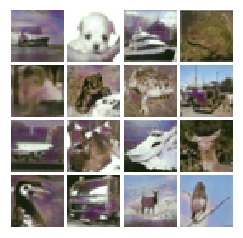

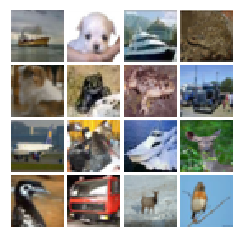

2900
159.18249124


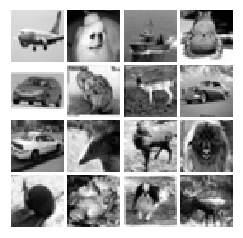

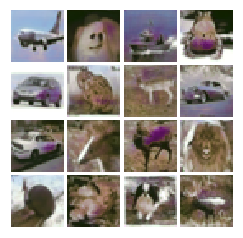

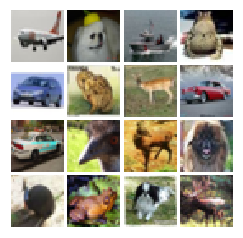

3000
180.172083488


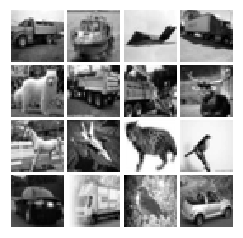

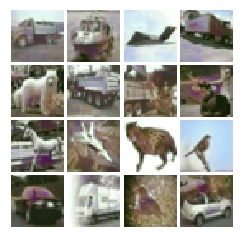

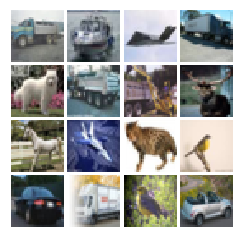

3100
170.675351919


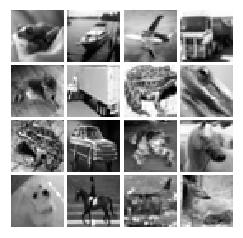

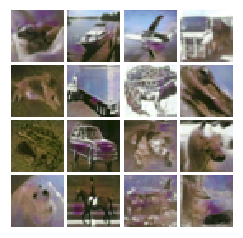

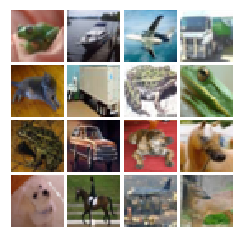

3200
255.67607168


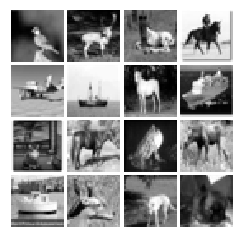

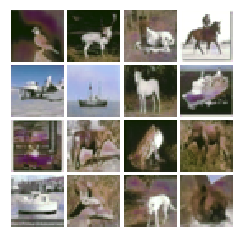

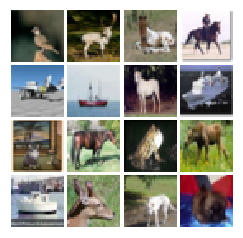

3300
254.230153088


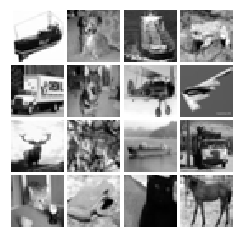

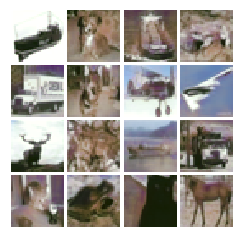

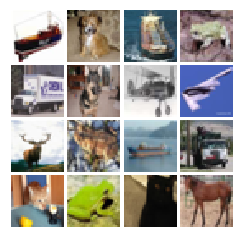

3400
168.482098875


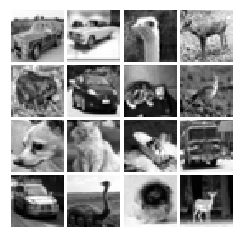

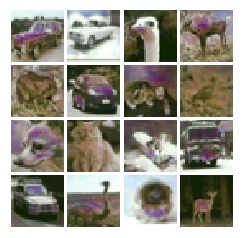

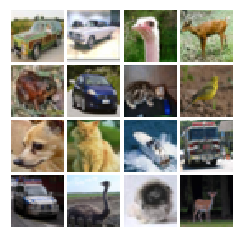

3500
168.840868405


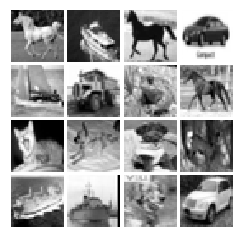

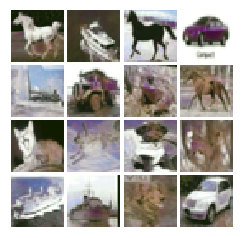

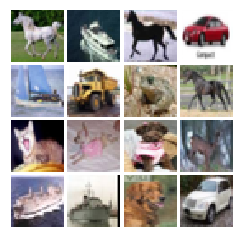

3600
185.955705353


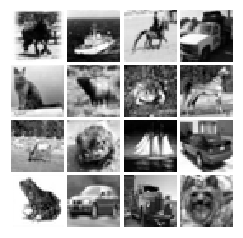

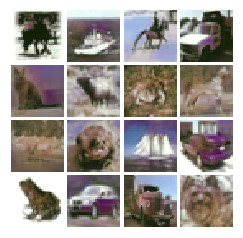

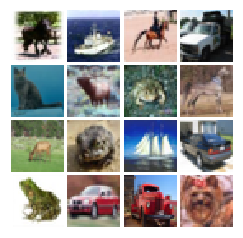

3700
179.423288314


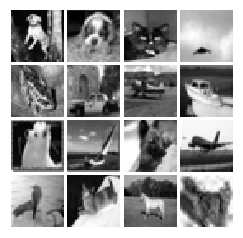

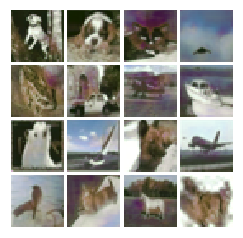

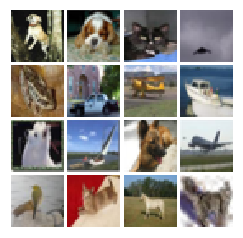

3800
240.707702781


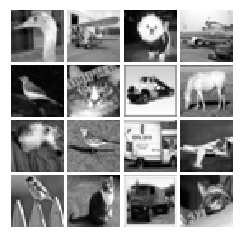

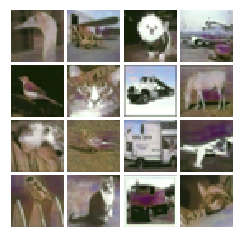

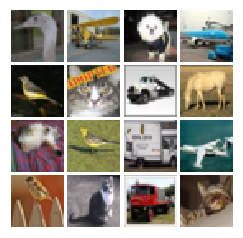

3900
219.21125207


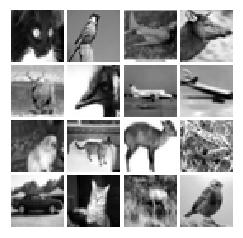

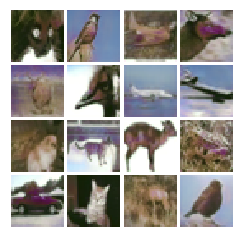

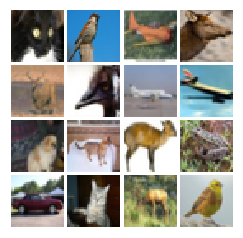

4000
288.7346598


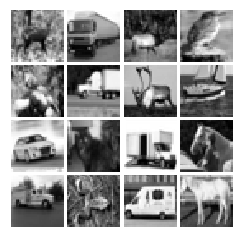

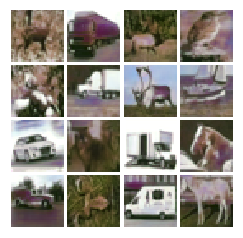

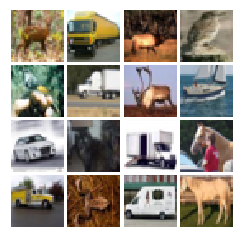

4100
154.867504771


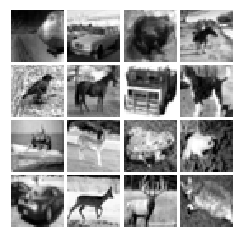

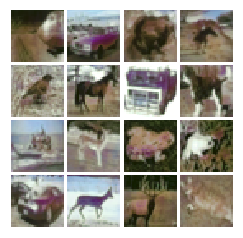

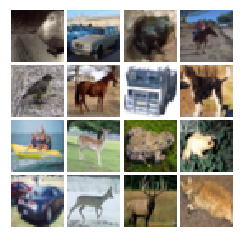

4200
159.549024423


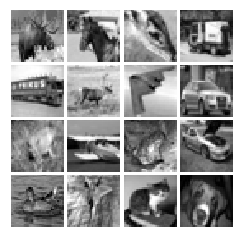

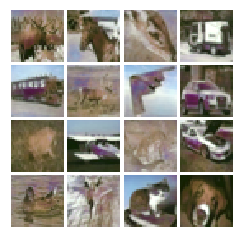

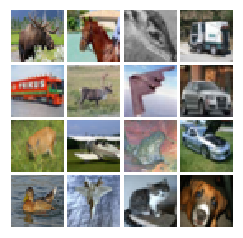

4300
236.131974815


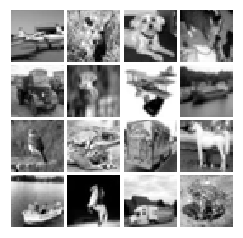

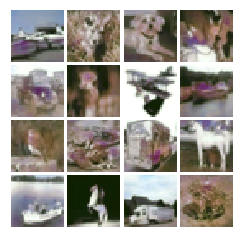

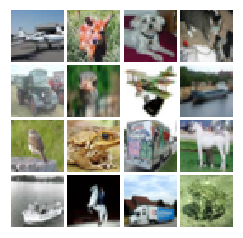

4400
167.432952129


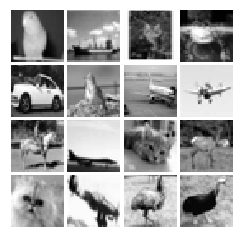

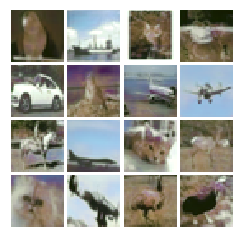

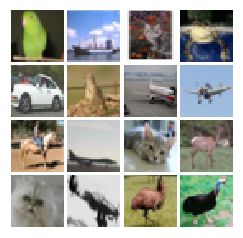

4500
197.305430061


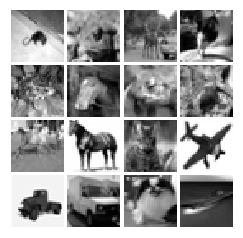

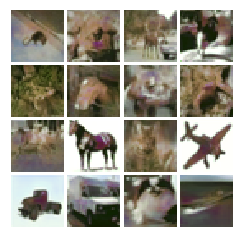

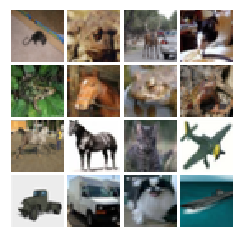

4600
169.859955702


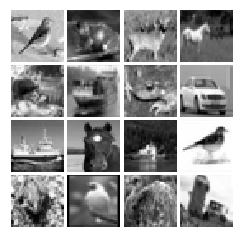

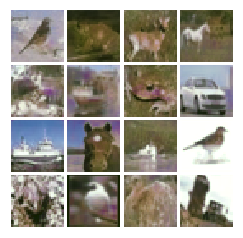

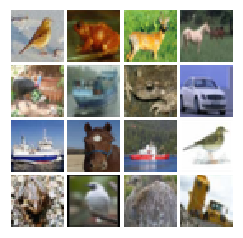

4700
288.385463601


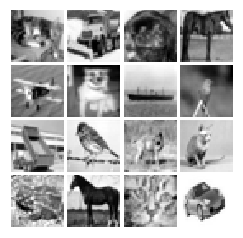

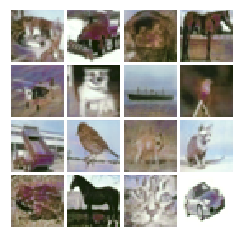

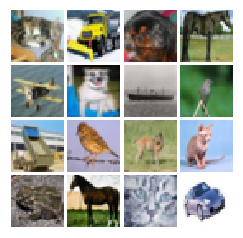

4800
186.35369762


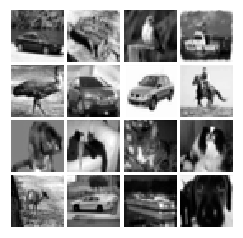

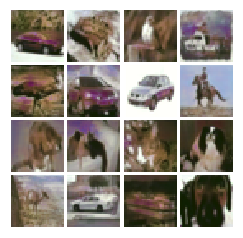

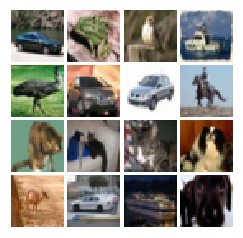

4900
171.057707535


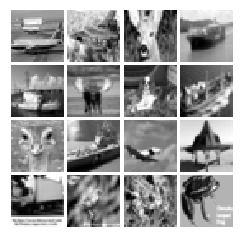

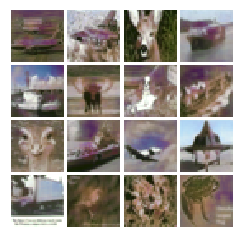

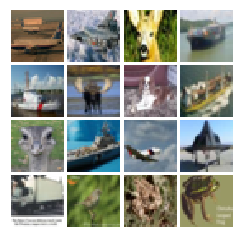

In [12]:
from skimage import img_as_float

tf.reset_default_graph()

X = tf.placeholder(tf.float32 ,[None ,32,32,3])
Y = tf.placeholder(tf.float32,[None,32,32,400])
is_training = tf.placeholder(tf.bool)

with tf.variable_scope("model") as scope: 
    UV_out,Y_in,UV_in = complex_pokemon_model3(X,is_training)
    reshaped_Y = tf.reshape(Y,shape = [-1,400])
    reshaped_UV_out = tf.reshape(UV_out,shape = [-1,400])
    loss_temp = tf.nn.softmax_cross_entropy_with_logits(logits = reshaped_UV_out,labels = reshaped_Y )
    weight_mat = tf.constant(wgt, shape=[400,])
    
    
    max_y = tf.argmax(Y, axis=3)
    y_reshaped = tf.reshape(max_y, shape=[tf.size(max_y)])
    weight = tf.gather(weight_mat, y_reshaped)
    
    weight = tf.reshape(weight, shape=[-1, 32, 32])
    loss_reshaped = tf.reshape(loss_temp,[-1,32,32])
    loss = tf.reduce_mean(weight*tf.cast(loss_reshaped, tf.float64))
    train_step = (tf.train.AdamOptimizer(1e-4).minimize(loss))

sess = tf.Session()
saver = tf.train.Saver()
#saver.restore(sess,'../models/image_net_pok_model_trained/new_model')

inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(5000):
    rand_indices = np.random.choice(50000,128,replace = False)
    samp = X_train[rand_indices]
    
    samp_float = (samp)
    samp_YUV = samp_float.dot(yuv_converter)
    prob_dist_batch = Prob_dist(samp_YUV)
    feed_dict = {X:samp, Y:prob_dist_batch, is_training:True}
    losses,UV_o,y_in,_ = sess.run([loss,UV_out,Y_in,train_step],feed_dict)
     
    if(i%100==0):    
        print(i)
        saver.save(sess,'../models/class_model/mod')
        print (losses)
        #samp_rgb = samp_YUV.dot(inv_mat)
        RGB_output = YUV2rgb(UV_o, y_in)
        show_images2(rgb2gray(samp[:16]))
        show_images(RGB_output[:16]) 
        show_images(samp[:16])

INFO:tensorflow:Restoring parameters from ../models/class_model/mod


INFO:tensorflow:Restoring parameters from ../models/class_model/mod


193.158518883


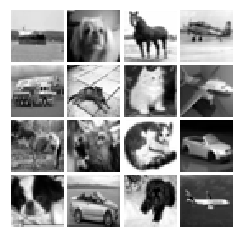

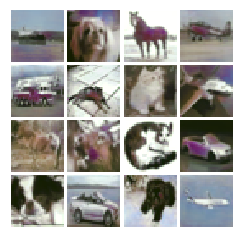

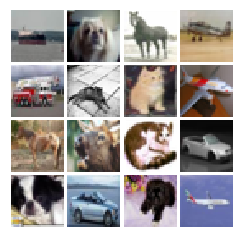

In [18]:
saver = tf.train.Saver()
saver.restore(sess,'../models/class_model/mod')

rand_indices = np.random.choice(10000,128,replace = False)
samp = X_test[rand_indices]
    
samp_float = (samp)
samp_YUV = samp_float.dot(yuv_converter)
samp_rgb = samp_YUV.dot(inv_mat)
prob_dist_batch = Prob_dist(samp_YUV)
feed_dict = {X:samp, Y:prob_dist_batch, is_training:True}
losses,UV_o,y_in,_ = sess.run([loss,UV_out,Y_in,train_step],feed_dict)
RGB_output = YUV2rgb(UV_o, y_in)
print (losses)
show_images2(rgb2gray(samp[:16]))
show_images(RGB_output[:16]) 
show_images(samp[:16])

In [ ]:
from Loss_metrics import AUC
X_test_sampled = X_test[:128*78,:,:,:]
batch_size = 128
X_test_model_gen = np.zeros([128*78,X_test.shape[1],X_test.shape[2],X_test.shape[3]])

for i in range(78):
    print (i)
    samp = X_test_sampled[i*128:(i+1)*128,:,:,:]
    samp_float = (samp)
    samp_YUV = samp_float.dot(yuv_converter)
    samp_rgb = samp_YUV.dot(inv_mat)
    prob_dist_batch = Prob_dist(samp_YUV)
    feed_dict = {X:samp, Y:prob_dist_batch, is_training:True}
    losses,UV_o,y_in,_ = sess.run([loss,UV_out,Y_in,train_step],feed_dict)
    RGB_output = YUV2rgb(UV_o, y_in)
    print (losses)
    #show_images2(rgb2gray(samp[:16]))
    #show_images(RGB_output[:16]) 
    #show_images(samp[:16])
    #samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
    #fig = show_images2(samples_gray[:16])
    #plt.show()
    #samples = sess.run(G_sample,feed_dict = {x:minibatch})
    #samples[samples>1] = 1
    #samples[samples<0]  =0 
    #print (np.amax(samples))
    #print (np.amin(samples))
    #fig = show_images(samples[:16])
    #plt.show()
    #fig = show_images(minibatch[:16])
    #plt.show()
    X_test_model_gen[i*128:(i+1)*128,:,:,:] = RGB_output[:,:,:,:]
 


rgb_i = X_test_sampled
rgb_o = X_test_model_gen
rand_indices = np.random.choice(np.arange(128*78),batch_size)
minibatch = rgb_o[rand_indices]
fig = show_images(minibatch[:16])
plt.show()
minibatch = rgb_i[rand_indices]
fig = show_images(minibatch[:16])
plt.show()
print(rgb_i.size)
print(rgb_o[0].size)
auc, ans = AUC(np.reshape(rgb_i, [128*78, 32, 32, 3]), np.reshape(rgb_o, [128*78, 32, 32, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)

0
169.680834334
1
223.533460918
2
200.851662936
3
167.711554894
4
178.480878498
5
292.523983607
6
243.958036589
7
232.529067281
8
174.252189586
9
171.279719885
10
330.780500869
11
172.102928179
12
175.285888931
13
191.054136876
14
179.944679913
15
171.648191657
16
165.349438116
17
202.937187536
18
165.81687175
19
171.588383232
20
172.746031264
21
207.252891482
22
223.595604172
23
221.530755579
24
168.471654054
25
187.74934651
26
166.574830664
27
153.178825347
28
226.993485316
29
170.652432043
30
166.533572124
31
186.909469214
32
230.276635311
33
261.744639371
34
221.515306504
35
167.025182479
36
199.535022903
37
212.030801

In [ ]:
def my_model(x,drop_o,is_training):
    
    W_conv = tf.get_variable("Wconv",shape = [7,7,3,32])
    b_conv = tf.get_variable("bconv",shape = [32])
    a1 = tf.nn.conv2d(x, W_conv, strides=[1,1,1,1], padding='SAME') + b_conv
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn1')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    W_conv2 = tf.get_variable("Wconv2",shape = [5,5,32,64])
    b_conv2 = tf.get_variable("bconv2",shape = [64])
    a1 = tf.nn.conv2d(a1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn2')
    a1 = tf.nn.relu(a1)
    
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    a1 = tf.nn.dropout(a1,drop_o)
   
    W_conv3 = tf.get_variable("Wconv3",shape = [3,3,64,96])
    b_conv3 = tf.get_variable("bconv3",shape = [96])
    a1 = tf.nn.conv2d(a1, W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn3')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.dropout(a1,drop_o)
    #a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    a1_flat = tf.reshape(a1,[-1,8*8*96])
    W1 = tf.get_variable("W1",shape = [8*8*96,1024])
    b1 = tf.get_variable("b1",shape = [1024])
    W2 = tf.get_variable("W2",shape = [1024,1024])
    b2 = tf.get_variable("b2",shape = [1024])
    W3 = tf.get_variable("W3",shape = [1024,10])
    b3 = tf.get_variable("b3",shape = [10])
    
    affine = tf.matmul(a1_flat,W1) + b1
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    affine = tf.matmul(affine,W2) + b2
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    y_out = tf.matmul(affine,W2) + b2
    return y_out

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
dropout = tf.placeholder(tf.float32, shape = ())

with tf.variable_scope("model") as scope:
    y_out = my_model(X,dropout,is_training)

mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = y_out,labels = y)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-4)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [ ]:
yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/cifar10_classification/classification_cifar10_model')

batch_size = 64
num_epochs = 78*2
num_correct = 0
num_total = 0
for i in range(num_epochs):
    X_test_samp = X_test_model_gen[i*64:(i+1)*64,:,:,:]
    
    #X_test_YUV = X_test_samp.dot(yuv_converter)
    #X_test_YUV[:,:,:,1:3] = 0
    
    #X_test_samp = X_test_YUV.dot(inv_mat)
    
    Y_test_samp = y_test[i*64:(i+1)*64]
    feed_dict ={X:X_test_samp,y:Y_test_samp,is_training:False,dropout:1}
    prediction = sess.run([y_out],feed_dict)
    
    y_pred = np.argmax(prediction[0],axis = 1)
    #print (y_pred.shape)
    #print()
    num_total += batch_size
    num_correct += sum(np.equal(y_pred, Y_test_samp))
print (num_correct/num_total)